In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()

In [2]:
ckpt = '/home/sergei/ckpt_slow_recover'

In [3]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [4]:
import ray
ray.init()

2021-01-27 11:39:13,458	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.26.78.149',
 'raylet_ip_address': '172.26.78.149',
 'redis_address': '172.26.78.149:6379',
 'object_store_address': '/tmp/ray/session_2021-01-27_11-39-12_563943_30376/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-27_11-39-12_563943_30376/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-27_11-39-12_563943_30376',
 'metrics_export_port': 56326,
 'node_id': 'eb42a31061f25943a06655de0e8aa285285f17c1'}

In [5]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [6]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)#CPU_Unpickler(f).load()#pickle.load(f)

/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning
2021-01-27 11:40:08,637	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 06dd86a2-608c-11eb-81c9-71cb9b74c026
Make environment KeyChest-v0 None {}


In [7]:
learner

<RLLearner env=<KeyChestGymEnv<KeyChest-v0>> feature_shape=(17,) epochs=2000 additional_feature_shape=(2,)>

In [8]:
ctx = learner._context

In [9]:
ox = ctx['obs_x']
oy = ctx['obs_y']
ax = ctx['action_x']

In [10]:
oy_pred = learner.model(f_t=ox, a_t=ax)
oy_pred_nosparse = learner.non_sparse_model(f_t=ox, a_t=ax)

In [11]:
(oy_pred - oy).pow(2).mean()

tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)

In [12]:
(oy_pred_nosparse - oy).pow(2).mean()

tensor(4.8705e-05, device='cuda:0', grad_fn=<MeanBackward0>)

<AxesSubplot:>

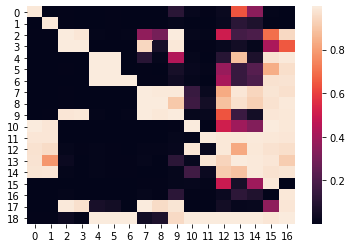

In [13]:
sns.heatmap(learner.model.Mf)

In [14]:
# most features are bad
(oy_pred - oy).pow(2).mean(0)

tensor([6.5183e-06, 1.0995e-06, 5.7509e-03, 3.2952e-03, 1.5009e-03, 1.1388e-02,
        2.2392e-03, 5.7157e-03, 2.6042e-03, 5.9495e-03, 5.2894e-03, 6.0712e-03,
        1.4462e-02, 2.2626e-02, 1.4590e-02, 6.2606e-04, 3.5184e-05],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [15]:
opt = torch.optim.Adam(params=learner.model.parameters(), lr=1e-3)

In [18]:
losses = []

In [19]:
for _ in tqdm(range(1000)):
    opt.zero_grad()
    oy_pred = learner.model(f_t=ox, a_t=ax)
    loss = (oy_pred - oy).pow(2).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())

KeyboardInterrupt: 

In [17]:
loss.item()

0.005889513064175844